Load model/tokenizer, and data. Fine-tune and evaluate.

In [1]:
#pip install matplotlib evaluate accelerate -U fugashi unidic-lite

In [1]:
import utils
from pathlib import Path
import wandb 
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict
import numpy as np
import pandas as pd
import evaluate
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import os

from scipy.stats import pearsonr, spearmanr

In [3]:
# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"]="JLPT-difficulty-classifier"
# save your trained model checkpoint to wandb
os.environ["WANDB_LOG_MODEL"]="true"
# turn off watch to log faster
os.environ["WANDB_WATCH"]="false"

In [4]:
data_split_dir = Path('/data/enrico_benedetti/nihongoexample/data/Webscraping/splits_val')
#gold_test_file = Path('/data/enrico_benedetti/nihongoexample/data/Webscraping/official_jlpt_gold/test.csv')
models_dir = Path('/data/enrico_benedetti/nihongoexample/preliminary phase/models')
log_dir = Path('/data/enrico_benedetti/nihongoexample/preliminary phase/logs')

In [4]:
id2label = {0: "N5", 1: "N4", 2: "N3", 3: "N2", 4: "N1"}
label2id = {v: k for k, v in id2label.items()}
label2id

{'N5': 0, 'N4': 1, 'N3': 2, 'N2': 3, 'N1': 4}

In [6]:
# docs, info at https://github.com/cl-tohoku/bert-japanese/
tokenizer = AutoTokenizer.from_pretrained("cl-tohoku/bert-base-japanese-v3")
model = AutoModelForSequenceClassification.from_pretrained("cl-tohoku/bert-base-japanese-v3", num_labels=5, id2label=id2label, label2id=label2id)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v3 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

In [7]:
only_train_data = False
if only_train_data:
    data_split_dir = Path('/data/enrico_benedetti/nihongoexample/data/Webscraping/splits')
    train_file = str(data_split_dir/'train.csv')
    # val_file = str(data_split_dir/'val.csv')
    test_file = str(data_split_dir/'test.csv')
    train = pd.read_csv(train_file, index_col=0)
    # val = pd.read_csv(val_file, index_col=0)
    test = pd.read_csv(test_file, index_col=0)
    df_train = Dataset.from_pandas(train, split='train', preserve_index=False)
    df_val = Dataset.from_pandas(train, split='val', preserve_index=False)
    df_test = Dataset.from_pandas(test, split='test', preserve_index=False)
    dataset = DatasetDict({'train': df_train, 'test': df_test})
else:
    data_split_dir = Path('/data/enrico_benedetti/nihongoexample/data/Webscraping/splits_val')
    data_files = {'test': 'test.csv', 'train': 'train.csv', 'val': 'val.csv'}
    dataset = load_dataset('csv', data_files=data_files, data_dir=data_split_dir)
assert(list(np.unique(dataset["train"]['level']))==['N1', 'N2', 'N3', 'N4', 'N5'])
print(dataset.shape)

{'test': (879, 3), 'train': (4924, 3), 'val': (260, 3)}


In [8]:
# should test for all 3
# map jlpt to numerical labels
#print(dataset['train'][0])
dataset = dataset.class_encode_column('level')
dataset = dataset.align_labels_with_mapping(label2id=label2id, label_column='level')

dataset['train'][0]

{'Unnamed: 0': 0, 'sentence': ' 医者たるもの、患者の命を優先に考えるべきだ。', 'level': 4}

In [9]:
# change names of columns to sentence and label

# dataset = dataset.rename_column('example', 'sentence')
dataset = dataset.rename_column("level", "labels")

In [10]:
# tokenizing with default everything

def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding=True)


tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [11]:
tokenized_dataset

DatasetDict({
    test: Dataset({
        features: ['Unnamed: 0', 'sentence', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 879
    })
    train: Dataset({
        features: ['Unnamed: 0', 'sentence', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4924
    })
    val: Dataset({
        features: ['Unnamed: 0', 'sentence', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 260
    })
})

In [12]:
metric1 = evaluate.load('accuracy')
metric2 = evaluate.combine(
    [
        evaluate.load("f1"),
        evaluate.load("precision"),
        evaluate.load('recall'),
        #evaluate.load("accuracy", average=None)
    ]
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    dict2 = metric2.compute(predictions=predictions, references=labels, average='weighted')
    dict1 = metric1.compute(predictions=predictions, references=labels)
    dict2[list(dict1.keys())[0]] = list(dict1.values())[0]

    # also compute correlation coefficients
    pearson = pearsonr(x=predictions, y=labels)
    spearman = spearmanr(a=predictions, b=labels)

    dict2['pearson'] = {'statistic': pearson.statistic, 'pvalue': pearson.pvalue}
    dict2['spearman'] = {'statistic': spearman.statistic, 'pvalue': spearman.pvalue}

    return dict2

In [13]:
# dict2 = metric2.compute(predictions=[0,1], references=[1,2], average='micro')
# dict1 = metric1.compute(predictions=[0,1], references=[1,2])
# dict2[list(dict1.keys())[0]] = list(dict1.values())[0]
# dict1, dict2

In [14]:
# device = utils.get_freer_gpu()
# print(device)
# torch.cuda.set_device(torch.device(device))

In [15]:
only_train_data

False

In [16]:
# instantiate trainer, pass everything
# https://huggingface.co/transformers/v3.0.2/main_classes/trainer.html#transformers.TrainingArguments

#train on cpu forn now
# device = torch.device('cpu')
# device = torch.device('cuda')
#model = model.to(device)
if only_train_data:
    training_args = TrainingArguments(
        #    label_names = ['level'],
        report_to="wandb",
        output_dir=models_dir,
        learning_rate=2e-5,
        logging_steps=100,
        do_train=True,
        do_eval=False,
        per_device_train_batch_size=8,
        num_train_epochs=10,
        adam_beta1=0.9,
        adam_beta2=0.999,
        adam_epsilon=1e-7,
        weight_decay=0.01
        )
    # automatically shuffles the examples
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

else:
    training_args = TrainingArguments(
        
    #    label_names = ['level'],
        report_to="wandb",
        output_dir=models_dir,
        learning_rate=2e-5,
        logging_steps=100,
        do_train=True,
        do_eval=True,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=10,
        prediction_loss_only=False,
        adam_beta1=0.9,
        adam_beta2=0.999,
        adam_epsilon=1e-7,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        save_total_limit = 3
    )
    # automatically shuffles the examples
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset['train'],
        eval_dataset=tokenized_dataset['val'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

#training_args.place_model_on_device("cpu")
training_args.device

device(type='cuda', index=0)

In [17]:
trainer.train()
#trainer.evaluate(eval_dataset=tokenized_dataset["test"])

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0, sentence. If Unnamed: 0, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/enrico_benedetti/anaconda3/envs/nlp_env/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 4924
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 770
  Number of trainable parameters = 111211013
Automatic Weights & Biases logging enabled, to disable set os.environ["WAN

/home/enrico_benedetti/anaconda3/envs/nlp_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy,Pearson,Spearman
1,No log,1.081716,0.512150,0.574144,0.538462,0.538462,"{'statistic': 0.7315321254799426, 'pvalue': 8.216522691512351e-45}","{'statistic': 0.740067235083334, 'pvalue': 2.372245801575872e-46}"
2,1.285400,0.736562,0.683290,0.691634,0.688462,0.688462,"{'statistic': 0.8537950437870736, 'pvalue': 4.2054125255581313e-75}","{'statistic': 0.8607539192321464, 'pvalue': 1.253505338740614e-77}"
3,0.767700,0.644334,0.762996,0.774760,0.761538,0.761538,"{'statistic': 0.8846885436253024, 'pvalue': 1.7215140350876817e-87}","{'statistic': 0.8887741942117423, 'pvalue': 2.1588247269911423e-89}"
4,0.473100,0.594489,0.805811,0.818146,0.803846,0.803846,"{'statistic': 0.9096808286867215, 'pvalue': 1.8881103001481483e-100}","{'statistic': 0.9121920783394821, 'pvalue': 5.870824504691129e-102}"
5,0.473100,0.598083,0.802266,0.813262,0.800000,0.800000,"{'statistic': 0.9028621646109533, 'pvalue': 1.433382322136185e-96}","{'statistic': 0.9039343591205539, 'pvalue': 3.6777870083186916e-97}"
6,0.279200,0.598141,0.824508,0.834341,0.823077,0.823077,"{'statistic': 0.9090775627118475, 'pvalue': 4.281216404209935e-100}","{'statistic': 0.9077911795626115, 'pvalue': 2.4070973902952044e-99}"
7,0.184200,0.601232,0.825003,0.836411,0.823077,0.823077,"{'statistic': 0.9138748645184298, 'pvalue': 5.408782644822959e-103}","{'statistic': 0.914928287013598, 'pvalue': 1.1856599856060119e-103}"
8,0.129700,0.587756,0.839766,0.849448,0.838462,0.838462,"{'statistic': 0.9214556684240018, 'pvalue': 6.15278218257436e-108}","{'statistic': 0.9221028395522967, 'pvalue': 2.208565346621335e-108}"
9,0.129700,0.611374,0.836152,0.846590,0.834615,0.834615,"{'statistic': 0.9177601216629251, 'pvalue': 1.814545217239263e-105}","{'statistic': 0.9179913009200507, 'pvalue': 1.2814606792448696e-105}"
10,0.095000,0.595576,0.847744,0.855961,0.846154,0.846154,"{'statistic': 0.9277097918941118, 'pvalue': 2.0876262714800853e-112}","{'statistic': 0.9276529154461246, 'pvalue': 2.301904697056057e-112}"


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0, sentence. If Unnamed: 0, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 260
  Batch size = 64
Saving model checkpoint to /data/enrico_benedetti/nihongoexample/preliminary phase/models/checkpoint-77
Configuration saved in /data/enrico_benedetti/nihongoexample/preliminary phase/models/checkpoint-77/config.json
Model weights saved in /data/enrico_benedetti/nihongoexample/preliminary phase/models/checkpoint-77/pytorch_model.bin
tokenizer config file saved in /data/enrico_benedetti/nihongoexample/preliminary phase/models/checkpoint-77/tokenizer_config.json
Special tokens file saved in /data/enrico_benedetti/nihongoexample/preliminary phase/models/checkpoint-77/special_tokens_map.json
Deleting older checkpoint [/data/enrico_benede

TrainOutput(global_step=770, training_loss=0.424492901021784, metrics={'train_runtime': 409.1342, 'train_samples_per_second': 120.352, 'train_steps_per_second': 1.882, 'total_flos': 2403933685191600.0, 'train_loss': 0.424492901021784, 'epoch': 10.0})

In [18]:
# on different splits of the test
if only_train_data:
    evaluation_sets = {'test': tokenized_dataset['test']}
else:
    evaluation_sets = {'test': tokenized_dataset['test'],
                'val': tokenized_dataset['val']}
evaluation_results = {}
# for source in sources:
#     test_sets[source] = tokenized_dataset['test'].filter(lambda example: example['source'] == source)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0, sentence. If Unnamed: 0, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 879
  Batch size = 64
/home/enrico_benedetti/anaconda3/envs/nlp_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


              precision    recall  f1-score   support

          N5       0.62      0.66      0.64       145
          N4       0.34      0.36      0.35       143
          N3       0.33      0.67      0.45       197
          N2       0.26      0.20      0.23       192
          N1       0.59      0.08      0.15       202

    accuracy                           0.38       879
   macro avg       0.43      0.39      0.36       879
weighted avg       0.42      0.38      0.34       879



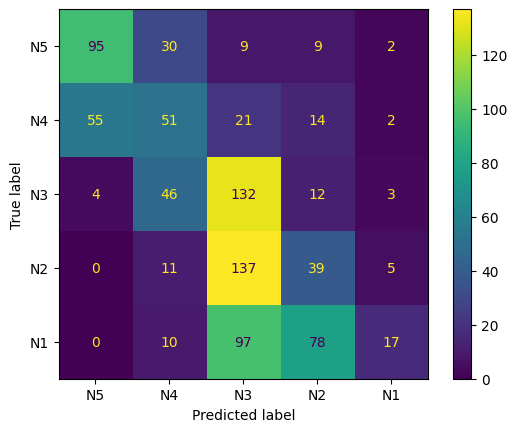

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: Unnamed: 0, sentence. If Unnamed: 0, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 260
  Batch size = 64
/home/enrico_benedetti/anaconda3/envs/nlp_env/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


              precision    recall  f1-score   support

          N5       0.88      0.88      0.88        25
          N4       0.90      0.89      0.90        53
          N3       0.78      0.90      0.84        62
          N2       0.71      0.79      0.75        47
          N1       0.95      0.77      0.85        73

    accuracy                           0.84       260
   macro avg       0.84      0.84      0.84       260
weighted avg       0.85      0.84      0.84       260



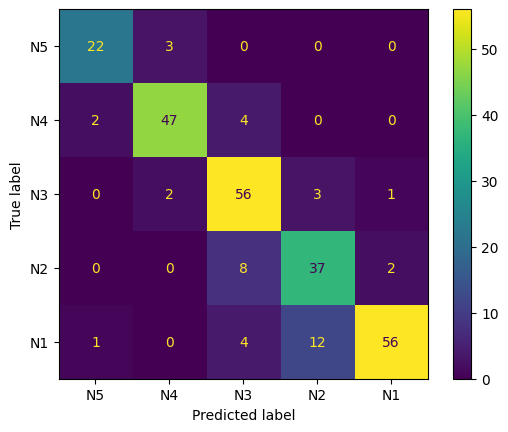

In [19]:
# on test sets
for key in evaluation_sets.keys():
    evaluation_results[key] = trainer.predict(evaluation_sets[key])
    evaluation_result = evaluation_results[key]
    # get predictions and charts for each key
    predicted_label_ids = np.argmax(evaluation_result.predictions, axis=-1)
    conf_matrix = confusion_matrix(y_true = evaluation_result.label_ids, y_pred = predicted_label_ids, normalize=None)
    class_report = classification_report(y_true = evaluation_result.label_ids, y_pred = predicted_label_ids, labels = list(id2label.keys()), target_names=list(id2label.values()))
    print(class_report)
    wandb.log({f'class_report_{key}': class_report})
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=list(label2id.keys()))
    disp.plot()
    wandb.log({f"conf_matrix_{key}": plt})
    plt.show()
    

In [20]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/accuracy,▁▄▆▇▇▇▇███
eval/f1,▁▅▆▇▇█████
eval/loss,█▃▂▁▁▁▁▁▁▁
eval/precision,▁▄▆▇▇▇████
eval/recall,▁▄▆▇▇▇▇███
eval/runtime,▂▁▁▃██████
eval/samples_per_second,▆██▅▁▁▁▁▁▁
eval/steps_per_second,▆██▅▁▁▁▁▁▁
train/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train/global_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██████
train/learning_rate,█▇▆▅▃▂▁


In [22]:
from transformers import TextClassificationPipeline

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, top_k=None, device=model.device)

test_input = "会話の中で質問を巧みに取り入れることで、深い理解が得られます。" # seems not really working well...
# test_input = '私は日本人です。'
classifier(test_input)

[[{'label': 'N2', 'score': 0.9620075821876526},
  {'label': 'N3', 'score': 0.028742173686623573},
  {'label': 'N1', 'score': 0.006371599156409502},
  {'label': 'N4', 'score': 0.002060162601992488},
  {'label': 'N5', 'score': 0.0008184990147128701}]]

In [5]:
# push to hub
# import wandb
# run = wandb.init()
# artifact = run.use_artifact('bennexx/jlpt-difficulty-classifier/model-0mtus4po:v0', type='model')
# artifact_dir = artifact.download()
# tokenizer = AutoTokenizer.from_pretrained(artifact_dir)
# model = AutoModelForSequenceClassification.from_pretrained(artifact_dir, num_labels=5, id2label=id2label, label2id=label2id)
# model.push_to_hub("cl-tohoku-bert-base-japanese-v3-jlpt-classifier")
# tokenizer.push_to_hub("cl-tohoku-bert-base-japanese-v3-jlpt-classifier")